# Itération 4

## Intitulé de l'itération

### 'age', 'weight', 'duration', 'heart_rate','body_temp','female', 'male'

### MinMaxScaler

### OneHotEncoder

### make_column_transformer

### Lasso

### Learning curve

## Import

In [6]:
import os
import psycopg2
from dotenv import load_dotenv

import pandas as pd
import numpy as np

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import learning_curve

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

# Affichage cellule
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_row', 1000)
from pprint import pprint

# Chargement du model pour déploiement
import pickle

## Connection à la DB sécurisé via des variables d'environnement

### création de la chaine de connexion

In [2]:


load_dotenv()  # Nécessaire pour charger les variables d'environnement précédemment définies

# Créer une connexion à postgres
connection = psycopg2.connect(host=os.environ.get('PG_HOST'),
                        user=os.environ.get('PG_USER'),
                        password=os.environ.get('PG_PASSWORD'),
                        dbname=os.environ.get('PG_DATABASE'))

connection.autocommit = True  # Assurez-vous que les données sont ajoutées à la base de données immédiatement après les commandes d'écriture.
cursor = connection.cursor()
cursor.execute('SELECT %s as connected;', ('Connection à postgres Réussie!',))
print(cursor.fetchone())

('Connection à postgres Réussie!',)


### Fonction de création du dataframe

In [3]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Transformer une requête SELECT en un dataframe pandas
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturellement, nous obtenons une liste de "tupples".
    tupples = cursor.fetchall()
    cursor.close()
    
    # Nous devons juste le transformer en dataframe pandas.
    df = pd.DataFrame(tupples, columns=column_names)
    return df

### Récupération de postgresql au dataframe

In [4]:
conn = connection
column_names = ["user_id","gender", "age", "height", "weight", "duration", "heart_rate", "body_temp", "calorie"]
# Execute the "SELECT *" query
df_db = postgresql_to_dataframe(conn, 
"SELECT persons.user_id as id, gender, age, height, weight, duration, heart_rate, body_temp,calorie FROM calories INNER JOIN persons ON calories.user_id = persons.user_id"
                                , column_names)
df_db.head()

,user_id,gender,age,height,weight,duration,heart_rate,body_temp,calorie
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [5]:
df_db.shape


(15000, 9)

In [5]:
# charge le dataframe 
df_db.to_csv('df_lasso.csv')

## Modele

In [7]:
# # utilisation des doubles crochets pour renvoyer un DataFrame pour la variable  X
X = df_db[['age', 'weight', 'duration', 'heart_rate','body_temp']]
# y unidimensionnel
y = df_db['calorie']

In [8]:
# encodage en one hot et mormalisation des données avec min max scaler avec column transformer

ohe=OneHotEncoder(sparse=False)
scaler = MinMaxScaler()
ct=make_column_transformer((ohe,['gender']),
                      (scaler,  ['duration','heart_rate','body_temp']),remainder='passthrough')
data_ct=ct.fit_transform(df_db)

# Encodage sur le genre et retransformation en dataframe pandas nommé dum
ohe_True=OneHotEncoder(sparse=True)
ohe_with_sparse=ohe_True.fit_transform(df_db['gender'].values.reshape(-1,1)).toarray()
ohe_with_sparse

dum=pd.get_dummies(df_db,columns=['gender'],prefix='',prefix_sep='')

In [9]:
dum.head()

,user_id,age,height,weight,duration,heart_rate,body_temp,calorie,female,male
0,14733363,68,190.0,94.0,29.0,105.0,40.8,231.0,0,1
1,14861698,20,166.0,60.0,14.0,94.0,40.3,66.0,1,0
2,11179863,69,179.0,79.0,5.0,88.0,38.7,26.0,0,1
3,16180408,34,179.0,71.0,13.0,100.0,40.5,71.0,1,0
4,17771927,27,154.0,58.0,10.0,81.0,39.8,35.0,1,0


In [10]:
X = dum[['age', 'weight', 'duration', 'heart_rate','body_temp','female', 'male']]
y = dum.calorie

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

### Lasso

In [11]:
from sklearn import linear_model
ls = linear_model.Lasso(alpha=0)
ls.fit(X_train,y_train)

Lasso(alpha=0)

#### Score

In [12]:
ls.score(X_test,y_test)

0.9661889410992279

In [13]:
# je fais ma prediction sur mon jeu de test
yPrediction = ls.predict(X_test)
# notre model décrit 91% des variations du calories brulées par rapport a la duréee d'exercice

In [14]:
# metriques 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

# Metrics
MAE = mean_absolute_error(y_test, yPrediction)
print("MAE: {}". format(MAE))
RMSE = mean_squared_error(y_test, yPrediction)
print("Root Mean Squared Error: {}". format(RMSE))
R2 = r2_score(y_test, yPrediction)
print("R2: {}". format(R2))
NMAE = median_absolute_error(y_test, yPrediction)
print("Median Mean Squared Error: {}". format(NMAE))

MAE: 8.475216637671668
Root Mean Squared Error: 133.46611497918232
R2: 0.9661889410992279
Median Mean Squared Error: 6.504548164553597


#### Courbe d'apprentissage

##### entrainement et cross val score

In [12]:
train_sizes, train_scores, test_scores = learning_curve(ls, X, y, cv=10, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

##### Calcul des métriques

In [13]:
# Nous allons maintenant calculé la moyenne et l'écart-type des scores d'entraînement et de test.
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

##### Tracer la courbe d'apprentissage avec R2

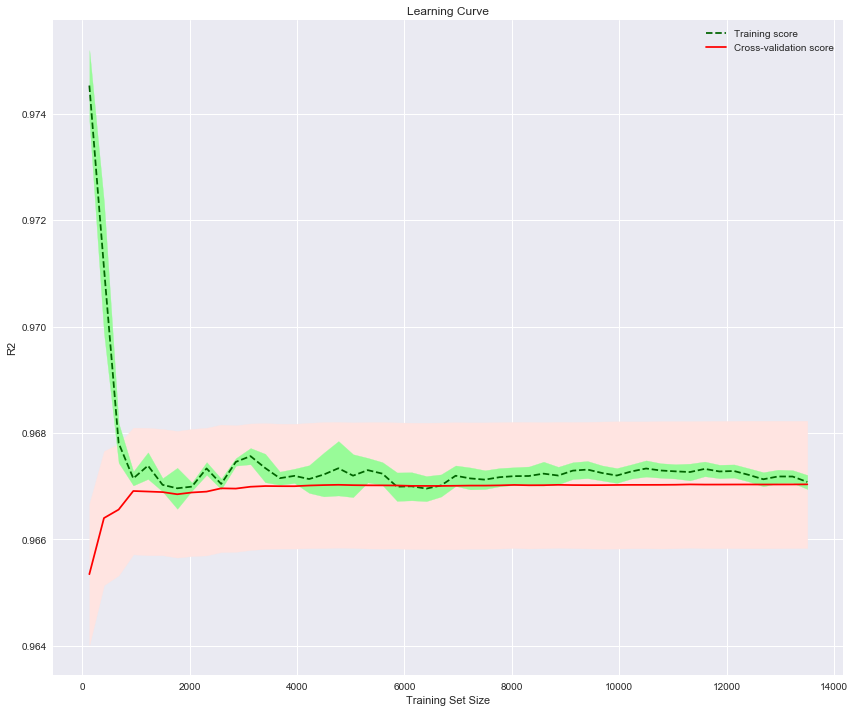

In [14]:
plt.subplots(1, figsize=(12,10))
plt.plot(train_sizes, train_mean, '--', color="darkgreen",  label="Training score")
plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="mistyrose")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="palegreen")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("R2"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

# a savoir la MSE pénalise bcp plus les grandes erreurs que la MAE
# MAE l'importanced'une erreur est linéaire avec son amplitude. si le dataset contient des **valeurs aberrantes**
print('MAE : ',mean_absolute_error(y_test, yPrediction))

# MSE si on accorde une grande importance aux garndes erreurs
print('RMSE : ',mean_squared_error(y_test, yPrediction))

print('Le coefficient de détermination ou R2 : ',r2_score(y_test, yPrediction))

# moins sensible au valeurs aberrantes
print('Mediane AE : Le model fais une erreur de prediction en moyenne de ',median_absolute_error(y_test, yPrediction), 'calories brulées ce qui est trés bien')

MAE :  8.475216637671657
RMSE :  133.4661149791823
Le coefficient de détermination ou R2 :  0.9661889410992279
Mediane AE : Le model fais une erreur de prediction en moyenne de  6.504548164553569 calories brulées ce qui est trés bien


## Pickle

### Créer un objet itérateur avec droit d'écriture - model.pkl

In [15]:
with open('model/lasso_pkl', 'wb') as files:
    pickle.dump(ls, files)